In [1]:
!pip install gensim
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Dataset
Training model with Random Embeddings...
Epoch 1, Loss: 7.3269
Epoch 2, Loss: 6.2420
Epoch 3, Loss: 5.3588
Epoch 4, Loss: 4.5496
Epoch 5, Loss: 3.8695
Epoch 6, Loss: 3.3461
Epoch 7, Loss: 2.9419
Epoch 8, Loss: 2.6182
Epoch 9, Loss: 2.3519
Epoch 10, Loss: 2.1309


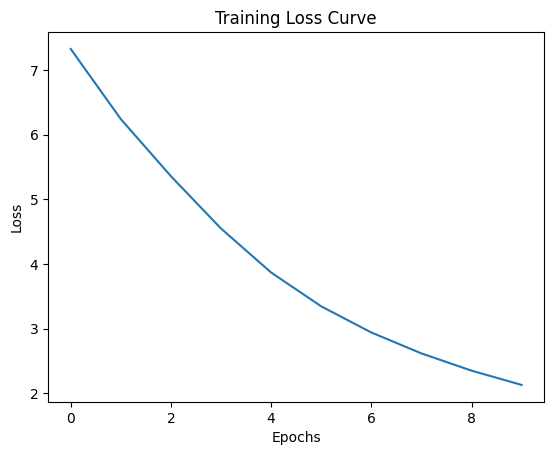

Training model with Pretrained Embeddings (GloVe)...
Epoch 1, Loss: 7.3535
Epoch 2, Loss: 6.5475
Epoch 3, Loss: 5.8965
Epoch 4, Loss: 5.2448
Epoch 5, Loss: 4.6535
Epoch 6, Loss: 4.1903
Epoch 7, Loss: 3.8647
Epoch 8, Loss: 3.6364
Epoch 9, Loss: 3.4617
Epoch 10, Loss: 3.3257


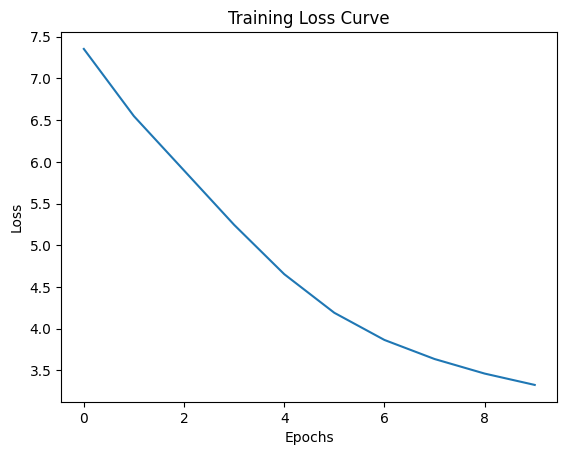

Random Embeddings - Perplexity: 24146.51, Accuracy: 47.74%
Pretrained Embeddings - Perplexity: 13769.18, Accuracy: 51.58%
                  Model  Accuracy  Perplexity
0  Without Augmentation     47.74    24146.51
1     With Augmentation     51.58    13769.18

Performance Metrics Comparison:

               Model  Accuracy  Perplexity
Without Augmentation     47.74    24146.51
   With Augmentation     51.58    13769.18
Generated text (Random Model): to be or not to be found. romeo: i have not been desirous of strange
Generated text (Pretrained Model): to be or not to approve them. polixenes: wherefore, let me not? to entreat me


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from gensim.models import KeyedVectors
import pandas as pd

# Load Dataset and Preprocess
def load_text_data():
    print("Fetching Dataset...")
    dataset = load_dataset("tiny_shakespeare", trust_remote_code=True)
    corpus = " ".join(dataset["train"]["text"]).lower().split()
    return corpus

data_corpus = load_text_data()
unique_words = sorted(set(data_corpus))
word_to_index = {word: idx for idx, word in enumerate(unique_words)}
index_to_word = {idx: word for word, idx in word_to_index.items()}
encoded_corpus = [word_to_index[word] for word in data_corpus]

split_point = int(0.8 * len(encoded_corpus))
training_data, testing_data = encoded_corpus[:split_point], encoded_corpus[split_point:]

# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, sequences, seq_length=10):
        self.sequences = sequences
        self.seq_length = seq_length

    def __len__(self):
        return len(self.sequences) - self.seq_length

    def __getitem__(self, idx):
        return (torch.tensor(self.sequences[idx:idx + self.seq_length], dtype=torch.long),
                torch.tensor(self.sequences[idx + self.seq_length], dtype=torch.long))

train_loader = DataLoader(TextDataset(training_data), batch_size=64, shuffle=True)
test_loader = DataLoader(TextDataset(testing_data), batch_size=64, shuffle=False)

# Vanilla RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, pretrained_weights=None):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained_weights))
            self.embedding.weight.requires_grad = False
        self.rnn_layer = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn_layer(x, hidden)
        return self.output_layer(out[:, -1, :]), hidden

    def initialize_hidden(self, batch_size):
        return torch.zeros(1, batch_size, 256)

# Load Pretrained Embeddings
def fetch_glove_embeddings(filepath, word_to_index, embed_dim=100):
    glove_model = KeyedVectors.load_word2vec_format(filepath, binary=False, no_header=True)
    embedding_matrix = np.random.randn(len(word_to_index), embed_dim)
    for word, idx in word_to_index.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
    return embedding_matrix

# Training Function
def train_rnn(model, data_loader, test_loader, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    loss_track = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            hidden_state = model.initialize_hidden(inputs.size(0)).to(device)
            preds, _ = model(inputs, hidden_state)
            loss = criterion(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_track.append(epoch_loss / len(data_loader))
        print(f"Epoch {epoch + 1} - Loss: {loss_track[-1]:.4f}")

    plt.plot(loss_track)
    plt.title("Loss Over Time")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

def generate_sequence(model, seed_text, max_words=10):
    model.eval()
    words_list = seed_text.lower().split()
    hidden_state = model.initialize_hidden(1).to(device)
    for _ in range(max_words):
        input_seq = torch.tensor([[word_to_index[word] for word in words_list[-10:]]], dtype=torch.long).to(device)
        with torch.no_grad():
            predictions, hidden_state = model(input_seq, hidden_state)
        next_word_id = torch.argmax(predictions, dim=-1).item()
        words_list.append(index_to_word[next_word_id])
    return ' '.join(words_list)

# Initialize Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Models and Train
random_init_model = SimpleRNN(len(unique_words), 128, 256).to(device)
glove_path = "/content/drive/MyDrive/GenAi/glove.6B.100d.txt"
pretrained_weights = fetch_glove_embeddings(glove_path, word_to_index, 100)
pretrained_model = SimpleRNN(len(unique_words), 100, 256, pretrained_weights).to(device)

print("Training Model (Random Embeddings)...")
train_rnn(random_init_model, train_loader, test_loader)
torch.save(random_init_model.state_dict(), "rnn_random.pth")

print("Training Model (Pretrained GloVe)...")
train_rnn(pretrained_model, train_loader, test_loader)
torch.save(pretrained_model.state_dict(), "rnn_pretrained.pth")

# Evaluation Metrics
def evaluate_model(model, loader):
    model.eval()
    loss_function = nn.CrossEntropyLoss()
    total_loss, correct_count, total_words = 0, 0, 0
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for input_data, target_labels in loader:
            input_data, target_labels = input_data.to(device), target_labels.to(device)
            hidden = model.initialize_hidden(input_data.size(0)).to(device)
            outputs, _ = model(input_data, hidden)
            loss = loss_function(outputs, target_labels)
            total_loss += loss.item() * input_data.size(0)
            predictions = torch.argmax(outputs, dim=-1)
            correct_count += (predictions == target_labels).sum().item()
            total_words += target_labels.numel()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target_labels.cpu().numpy())

    avg_loss = total_loss / total_words
    perplexity = np.exp(avg_loss)
    accuracy = (correct_count / total_words) * 100
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    return perplexity, accuracy, conf_matrix

rand_ppl, rand_acc, cm_rand = evaluate_model(random_init_model, test_loader)
pretrained_ppl, pretrained_acc, cm_pretrained = evaluate_model(pretrained_model, test_loader)

print(f"Random Model - Perplexity: {rand_ppl:.2f}, Accuracy: {rand_acc:.2f}%")
print(f"Pretrained Model - Perplexity: {pretrained_ppl:.2f}, Accuracy: {pretrained_acc:.2f}%")

# Generate Text
start_text = "to be or not to"
print("Generated (Random):", generate_sequence(random_init_model, start_text))
print("Generated (Pretrained):", generate_sequence(pretrained_model, start_text))


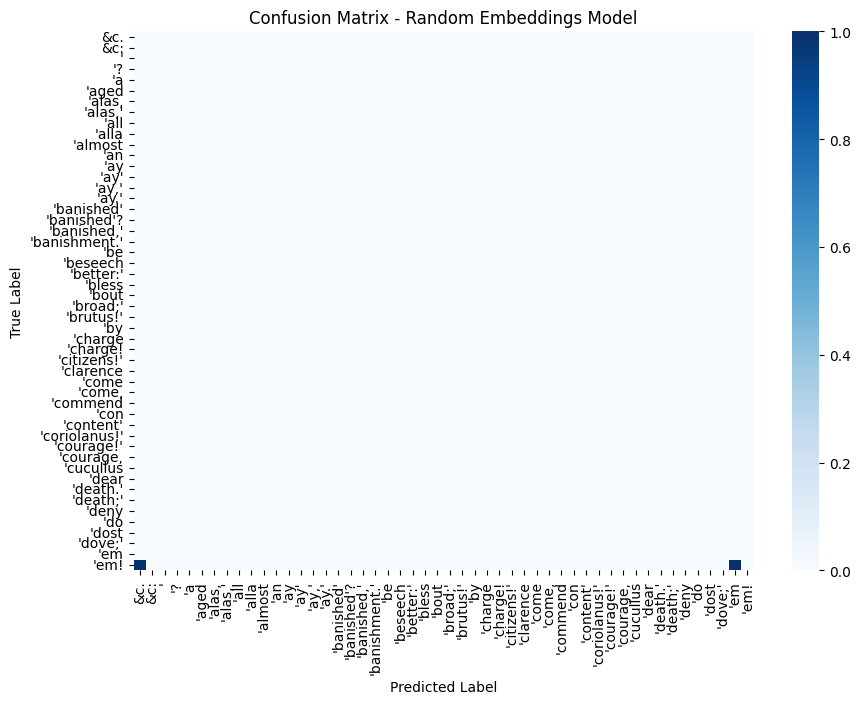

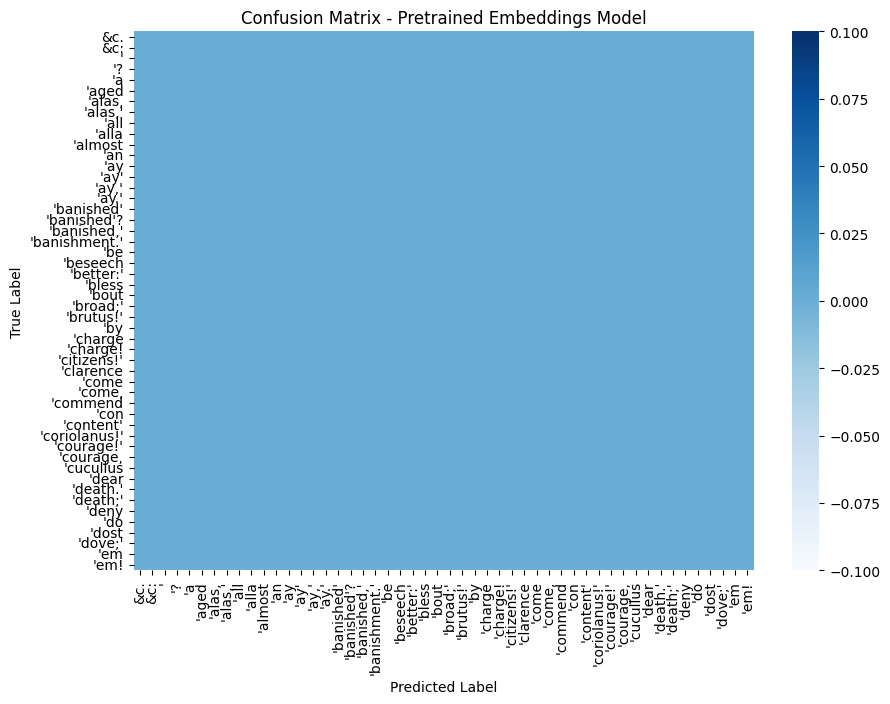

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_matrix, vocab, model_name, num_labels=50):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix[:num_labels, :num_labels], annot=False, fmt="d", cmap="Blues",
                xticklabels=vocab[:num_labels], yticklabels=vocab[:num_labels])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(cm_rand, unique_words, "Random Embeddings Model")
plot_confusion_matrix(cm_pretrained, unique_words, "Pretrained Embeddings Model")